In [16]:
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import numpy as np
import copy
import random

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

!nvidia-smi

cuda
Wed Aug 10 15:01:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   5227MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
library = loadmat("/content/drive/MyDrive/ColabData/MUA-SparseUnmixing/spectral_library_urban.mat", squeeze_me = True)
label_names = library["material_names"].astype(str)
X = loadmat("/content/drive/MyDrive/ColabData/MUA-SparseUnmixing/Urban_R162.mat", squeeze_me = True)
wl, X, H, W = np.linspace(400, 2500, 224)[X["SlectBands"]], X["Y"].astype(float) / X["maxValue"], X["nRow"], X["nCol"]
X = X.T

library.keys(), library["A"].shape, X.shape

(dict_keys(['__header__', '__version__', '__globals__', 'A', 'lib1', 'lib2', 'lib3', 'lib4', 'lib5', 'lib6', 'material_names']),
 (162, 651),
 (94249, 162))

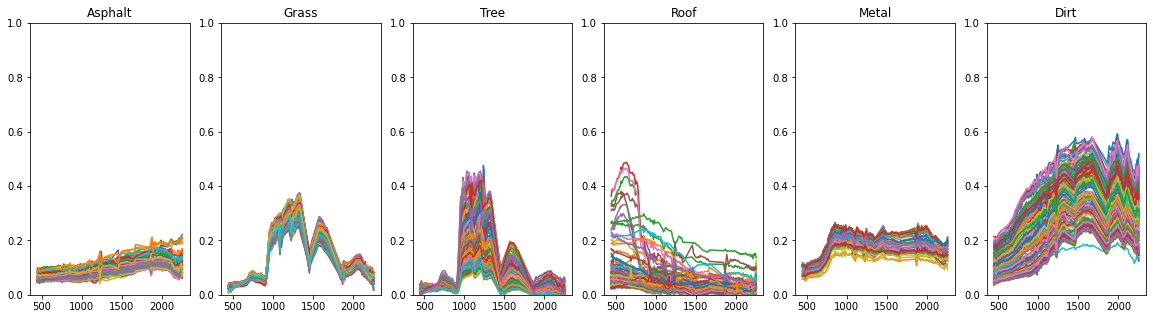

(651, 162) (651,)
torch.Size([651, 162]) True 651
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68]), array([ 69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168]), array([169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
      

In [20]:
e_full, labels_full = None, None
n_class = 6
plt.figure(figsize = [20, 5])

E_ranges, E_ctr = [], 0

for c in range(n_class):
    temp = library["lib" + str(c+1)].T
    if e_full is None: 
        e_full = temp
        labels_full = np.ones(len(e_full)) * c
    else: 
        e_full = np.vstack((e_full, temp))
        labels_full = np.concatenate((labels_full, np.ones(len(temp)) * c))
    E_ranges.append(np.arange(E_ctr, E_ctr + len(temp)))
    E_ctr += len(temp)
    plt.subplot(1, 6, c+1)
    plt.plot(wl, temp.T)
    plt.ylim([0, 1])
    plt.title(label_names[c])
plt.show()

print(e_full.shape, labels_full.shape)

X = torch.Tensor(X).to(device)
X.requires_grad = False

E = torch.FloatTensor(e_full)
E = E.to(device)
E.requires_grad = False

print(E.shape, E.is_cuda, len(labels_full))
labels_full = torch.IntTensor(labels_full).to(device)

print(E_ranges)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import division

from torch.nn.modules.loss import _Loss

def BrayCurtisSimilarity(X, X_hat):
    return (torch.abs(X - X_hat).sum(dim = 1) / (X.sum(dim = 1) + X_hat.sum(dim = 1))).mean()


def SID(X, X_hat):
    p = (X / X.sum(dim = 1, keepdim = True)) + 1e-3
    q = (X_hat / X_hat.sum(dim = 1, keepdim = True)) + 1e-3
    return torch.sum(p * torch.log(p / q) + q * torch.log(q / p), dim = 1).mean()

def COS(X, X_hat):
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    return 1 - (X * X_hat).sum(dim = 1) / (X_norm * X_hat_norm)

def SAD(X, X_hat):
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    return torch.acos(inner_product / (X_norm * X_hat_norm)).mean()

def SIDSAM(X, X_hat):
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    alpha = torch.acos(inner_product / (X_norm * X_hat_norm))

    p = (X / X.sum(dim = 1, keepdim = True))
    q = (X_hat / X_hat.sum(dim = 1, keepdim = True))
    sid =  torch.sum(p * torch.log(p / q + 1) + q * torch.log(q / p + 1), dim = 1)

    return (sid * torch.tan(alpha)).mean()

def JMSAM(X, X_hat):
    m_t, m_r = X.mean(dim = 1), X_hat.mean(dim = 1)
    sigma_t, sigma_r = X.var(dim = 1), X_hat.var(dim = 1)
    sigma_avg = (sigma_t + sigma_r) / 2
    B = 1/8 * (m_t - m_r)**2 / sigma_avg + 1/2*torch.log(torch.abs(sigma_avg) / torch.sqrt(sigma_t * sigma_r))
    X_norm, X_hat_norm = X.norm(p = 2, dim = 1), X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    alpha = torch.arccos(inner_product / (X_norm * X_hat_norm))
    return (2*(1-torch.exp(-B))*torch.tan(alpha)).mean()

def NS3(X, X_hat):
    _, B = X.shape
    l2_dist = torch.sqrt(((X - X_hat) ** 2).sum(dim = 1)/B)
    X_norm = X.norm(p = 2, dim = 1)
    X_hat_norm = X_hat.norm(p = 2, dim = 1)
    inner_product = (X * X_hat).sum(dim = 1)
    cos_alpha = inner_product / (X_norm * X_hat_norm)

    lower, upper = torch.min(X, dim = 1)[0], torch.max(X, dim = 1)[0]
    l2_dist = (l2_dist - lower) / (upper - lower)
    return torch.sqrt(l2_dist**2 + (1 - cos_alpha)**2).mean()

class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()
        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.
        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size
        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor
        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

class ParingLayer(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(n_features, n_features))

    def forward(self, H, V):
        return H @ self.weight @ V.T


def plot_all_endmembers(x, a, wl, E, labels, label_names):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if isinstance(E, torch.Tensor):
        E = E.detach().cpu().numpy()
    indices = np.where(a != 0)[0]

    plt.subplot(1, 2, 1)
    plt.plot(wl, x.T, c = "b", label = "real")
    plt.plot(wl, (a @ E).T, c = "r", label = "reconstructed")
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    for idx in indices:
        plt.plot(wl, E[idx].T, alpha = a[idx] * 10, 
                 label = label_names[labels[idx]] + "#" + str(idx) + " " + str(np.round(a[idx], 2)))
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    
def plot_all_endmembers_merges(x, a, wl, E, labels, label_names):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    if isinstance(E, torch.Tensor):
        E = E.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.plot(wl, x.T, c = "b", label = "real")
    plt.plot(wl, (a @ E).T, c = "r", label = "reconstructed")
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    for c in range(6):
        flag = (a > 0) & (labels == c)
        if np.any(flag):
            weighted_mean = np.average(E[flag], weights=a[flag], axis = 0)
            plt.plot(wl, weighted_mean.T, label = label_names[c] + " " + str(np.round(a[flag].sum(), 2)))
            # print(label_names[c], np.round(a[flag].sum(), 2))
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    

# plot_all_endmembers(x[0], A[0], wl[bbl_flag == 1], E, labels_full, label_names)
# plot_all_endmembers_merges(x[0], A[0], wl[bbl_flag == 1], E, labels_full, label_names)

# Full batch MLP 

epoch 0, loss: 0.0112803
epoch 1, loss: 0.0081654
epoch 2, loss: 0.0063398
epoch 3, loss: 0.0051339
epoch 4, loss: 0.0041793
epoch 5, loss: 0.0036112
epoch 6, loss: 0.0031430
epoch 7, loss: 0.0026879
epoch 8, loss: 0.0023380
epoch 9, loss: 0.0021068
epoch 10, loss: 0.0019549
epoch 11, loss: 0.0018468
epoch 12, loss: 0.0017593
epoch 13, loss: 0.0016783
epoch 14, loss: 0.0015987
epoch 15, loss: 0.0015237
epoch 16, loss: 0.0014561
epoch 17, loss: 0.0013970
epoch 18, loss: 0.0013462
epoch 19, loss: 0.0013014
epoch 20, loss: 0.0012606
epoch 21, loss: 0.0012228
epoch 22, loss: 0.0011874
epoch 23, loss: 0.0011553
epoch 24, loss: 0.0011275
epoch 25, loss: 0.0011037
epoch 26, loss: 0.0010830
epoch 27, loss: 0.0010642
epoch 28, loss: 0.0010465
epoch 29, loss: 0.0010297
epoch 30, loss: 0.0010137
epoch 31, loss: 0.0009988
epoch 32, loss: 0.0009847
epoch 33, loss: 0.0009709
epoch 34, loss: 0.0009574
epoch 35, loss: 0.0009446
epoch 36, loss: 0.0009325
epoch 37, loss: 0.0009212
epoch 38, loss: 0.0009

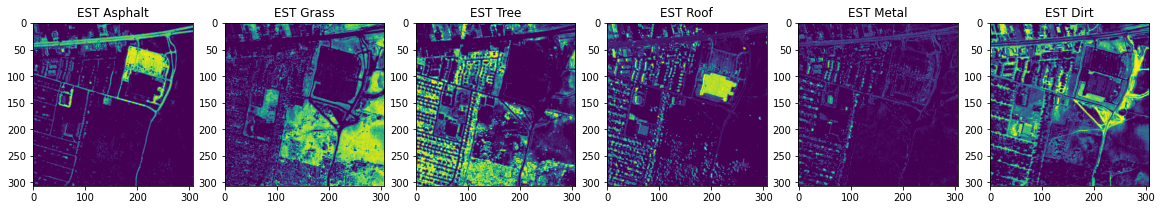

In [22]:
class MyMLP(nn.Module):

    class Embedding(nn.Module):
        def __init__(self, n_features, library_size):
            super().__init__()
            self.weight = nn.Parameter(torch.rand(n_features, library_size))

        def forward(self, H):
            return H @ self.weight

    def __init__(self, B, library_size):
        super(MyMLP, self).__init__()

        self.fc1 = nn.Linear(B, B//2)
        self.bn1 = nn.BatchNorm1d(B//2)
        self.fc2 = nn.Linear(B//2, B//4)
        self.bn2 = nn.BatchNorm1d(B//4)
        self.fc3 = nn.Linear(B//4, B//8)
        self.bn3 = nn.BatchNorm1d(B//8)

        self.spectra_encoder = [(self.fc1, self.bn1, nn.ReLU()), 
                                (self.fc2, self.bn2, nn.ReLU()),
                                (self.fc3, self.bn3, nn.Tanh())]

        self.embeddings = nn.Linear(B//8, library_size, bias = False)

        for fc in [self.fc1, self.fc2, self.fc3, self.embeddings]:
            torch.nn.init.xavier_normal_(fc.weight)
        
    def encoding_spectra(self, X):
        H = X
        for fc, bn, activation in self.spectra_encoder:
            H = fc(H)
            if bn is not None: H = bn(H)
            if activation is not None: H = activation(H)
        return H

    def forward(self, X):
        H = self.encoding_spectra(X)
        inner_product = self.embeddings(H)
        A = Sparsemax(dim = 1)(inner_product)
        return A


from collections import Counter
ctr = Counter(labels_full.detach().cpu().numpy())
foo = [ctr[key] for key in range(6)]

endmember_ranges, acc = [], 0
for i in range(6):
    endmember_ranges.append(np.arange(acc, acc + foo[i]))
    acc += foo[i]

def merge_full_to_6(A, endmember_ranges):
    A_merged = np.zeros((len(A), 6))
    for i in range(len(A)):
        row = A[i]
        for j in range(len(endmember_ranges)):
            A_merged[i, j] = np.sum(row[endmember_ranges[j]])
    return A_merged

def merge_6_to_3(A):
    A_merged = np.zeros((len(A), 3))
    gv_indices = np.array([0, 5])
    pervious_indices = np.array([1, 4])
    impervious_indices = np.array([2, 3])
    A_merged[:, 0] = np.sum(A[:, gv_indices], axis = 1)
    A_merged[:, 1] = np.sum(A[:, pervious_indices], axis = 1)
    A_merged[:, 2] = np.sum(A[:, impervious_indices], axis = 1)
    return A_merged



import time
cleanup, verbose = True, False
cleanup_threshold = 1e-2 
lr, individual_maes, merged_maes = 1e-3, [], []

for seed in range(1):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    model = MyMLP(162, len(E)).to(device)
    start_time = time.time()
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = 1e-2)

    for epoch in range(500):
        model.train()
        A = model(X)
        
        if epoch >= 200 and cleanup:
            mask = torch.ones(A.shape).to(device) 
            mask[A <= cleanup_threshold] = 0
            A *= mask
            A /= A.sum(dim = 1, keepdim = True)

        X_hat = A @ E

        optimizer.zero_grad()
        total_loss = nn.MSELoss(reduction = "mean")(X_hat, X) 
        total_loss.backward()
        optimizer.step()

        print("epoch %d, loss: %.7f" % (epoch, total_loss.detach().item()))
    print("\nexecution time: %.3f, seed: %d," %(time.time() - start_time, seed), "cleanup?", cleanup)
    print("arch:", model.spectra_encoder, "\noptimizer:", optimizer)


    A_est = merge_full_to_6(A.detach().cpu().numpy(), endmember_ranges)
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize = [20, 3])
    for c in range(6):
        axs[c].imshow((A_est[:, c].reshape((H, W)).T), aspect="auto")
        axs[c].set_title("EST " + label_names[c])
    plt.show()


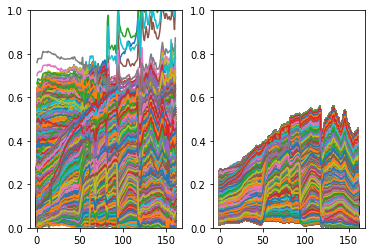

tensor(0.0196, device='cuda:0', grad_fn=<SqrtBackward0>)

In [23]:
plt.subplot(1, 2, 1)
plt.plot(X.detach().cpu().detach().numpy().T)
plt.ylim([0, 1])
plt.subplot(1, 2, 2)
plt.plot((A @ E).cpu().detach().numpy().T)
plt.ylim([0, 1])
plt.show()

torch.sqrt(torch.nn.MSELoss(reduction = "mean")(X, A @ E))

8.037432757907245 154 651


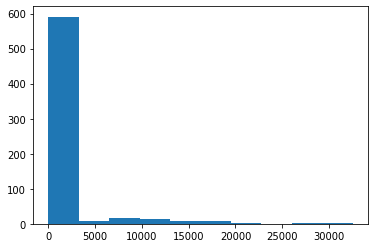

In [24]:
print(np.count_nonzero(A.detach().cpu().numpy(), axis = 1).mean(), np.count_nonzero(np.count_nonzero(A.detach().cpu().numpy(), axis = 0)), len(E))
plt.hist(np.count_nonzero(A.detach().cpu().numpy(), axis = 0))
plt.show()

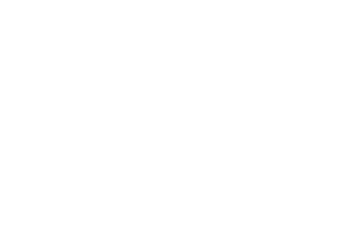

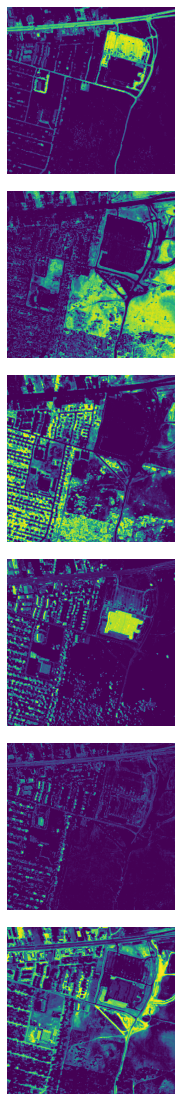

In [25]:
A_est = merge_full_to_6(A.detach().cpu().numpy(), endmember_ranges)
plt.axis('off')
fig, axs = plt.subplots(nrows=6, ncols=1, figsize = [3, 20])
for c in range(6):
    axs[c].imshow((A_est[:, c].reshape((H, W)).T), aspect="auto")
    axs[c].axis('off')
    plt.subplots_adjust(hspace = .1)
plt.show()

In [26]:
np.count_nonzero(A.detach().cpu().numpy(), axis = 1).mean()
E.shape

torch.Size([651, 162])